In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.signal as signal
from torch.optim import Adam, AdamW

from UnetAttn.Noise import Noise
from UnetAttn.Model1D import UNet1DAttn

from tqdm import tqdm

device = "cuda"
LABEL = "S_norm"

In [2]:
def return_samples(LABEL, data):
    index = {"F_norm": [a for a in range(417,712)],
             "N_norm": [a for a in range(2,1002)],
             "Q_norm": [a for a in range(46,1133)],
             "S_norm": [a for a in range(1953, 2721)],
             "V_norm": [a for a in range(854, 1295)]}
    
    y = data[index[LABEL]]
    # y = y.reshape(y.shape[0], 1, y.shape[-1])
    
    return y

def batching(a, n):
    n = min(n, len(a))
    k, m = divmod(len(a), n)
    
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))


def loader(label, batch_size, resample):
    data = pd.read_pickle("./data/"+label+".pkl")
    
    X = np.array(data["beat"].to_list())
    X = signal.resample(X, resample, axis=1)
    X = return_samples(label, X)
    n = len(X) // batch_size 
    a = range(n*batch_size)
    # n = int(len(data)/batch_size)-1
    
    batches = list(batching(a, n))
    X = torch.Tensor(X)
    # X = torch.cat([X, torch.zeros((X.shape[0], 512-X.shape[1]))], dim=1)
    
    return X, batches

def augment_image(data, batches):
    images = []
    for b in range(len(batches)):
        tmp = data[batches[b]]
        if tmp.shape == data[batches[0]].shape:
            tmp = tmp.unsqueeze(0)
            images.append(tmp)
    
    return images

def vis(signals):
    plt.plot(signals.squeeze(1).transpose(0,1))

torch.Size([768, 1, 256])


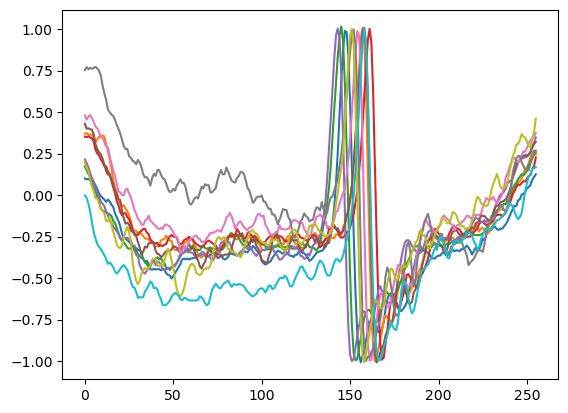

In [3]:
data, batches = loader(LABEL, 128, 256)
data= data.unsqueeze(1)
print(data.shape)

# images = torch.stack(augment_image(data, batches),dim=0)
# images = images[:64,:,:,:]
# print(images.shape)
batch_size = 128
batches = list(batching(range(len(data)), int(len(data)/batch_size)+1))

vis(data[batches[0]][:10])
plt.show()



# plt.imshow(data[batches[1]])


# # data = augment_image(data, batches)


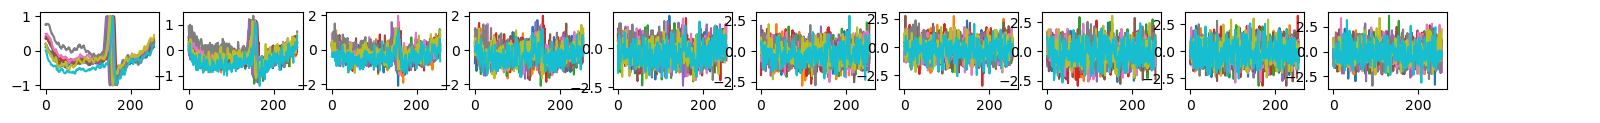

In [4]:

T = 300
obj = Noise(T, start=0.0001, end = 0.02)

plt.figure(figsize=(20,1))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = obj.forward_diffusion_sample(data[batches[0]][:10].squeeze(0), t)
    plt.plot(img.cpu().squeeze(1).transpose(0,1))

In [5]:

model = UNet1DAttn()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  20059845


In [6]:
def get_loss(model, x_0, t):
    x_noisy, noise = obj.forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

In [7]:
@torch.no_grad()
def sample_timestep(x, t):

    betas_t = obj.get_index_from_list(obj.betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = obj.get_index_from_list(obj.sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = obj.get_index_from_list(obj.sqrt_recip_alphas, t, x.shape)
    
    pred = model(x, t)
    mu = sqrt_recip_alphas_t * (x - betas_t * pred / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = obj.get_index_from_list(obj.posterior_variance, t, x.shape)
    
    if t == 0:
        return mu
    else:
        noise = torch.randn_like(x)
        return mu + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    img = torch.randn((16, 1, 256), device=device)
    plt.figure(figsize=(20,1))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)

        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.plot(img.detach().cpu()[0].squeeze(0))
    plt.show()
    return img            

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.5396893620491028 


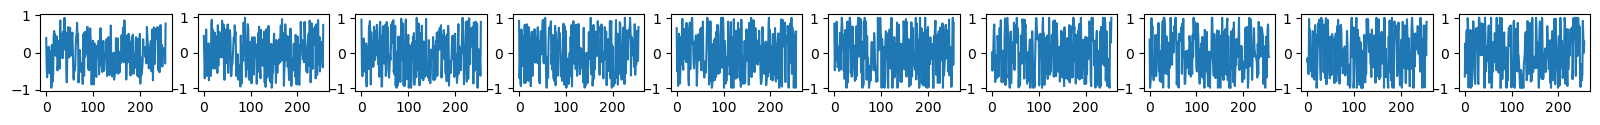

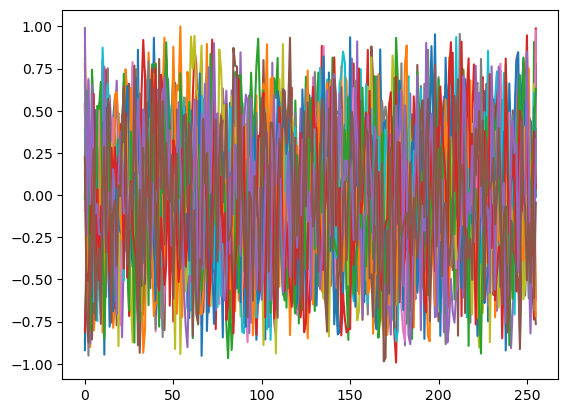

 20%|██        | 100/500 [00:29<01:48,  3.68it/s]

Epoch 100 | Loss: 0.010780740529298782 


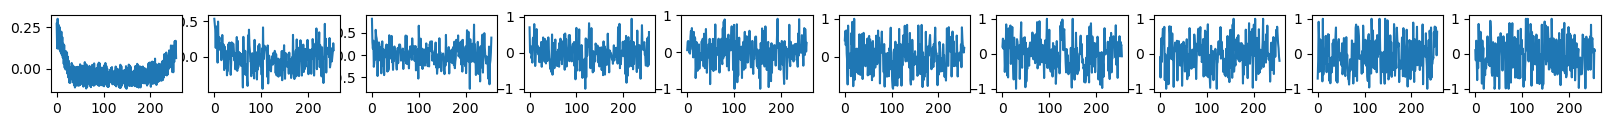

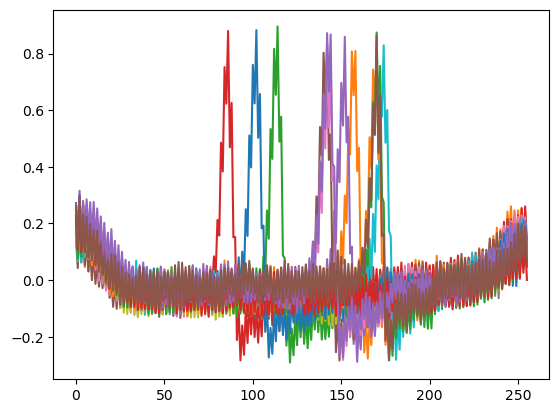

 40%|████      | 200/500 [00:59<01:28,  3.38it/s]

Epoch 200 | Loss: 0.039277561008930206 


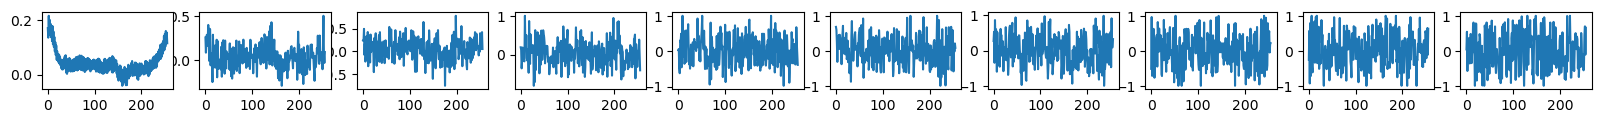

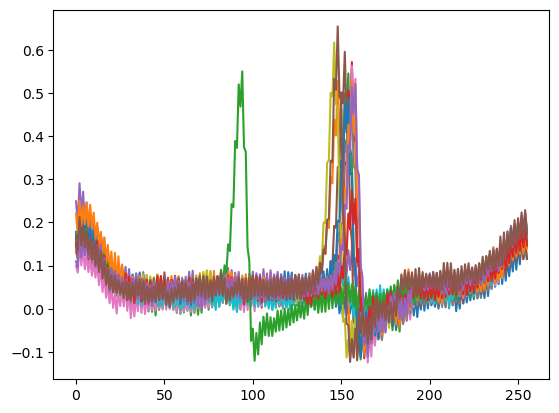

 60%|██████    | 300/500 [01:29<00:55,  3.59it/s]

Epoch 300 | Loss: 0.004178345203399658 


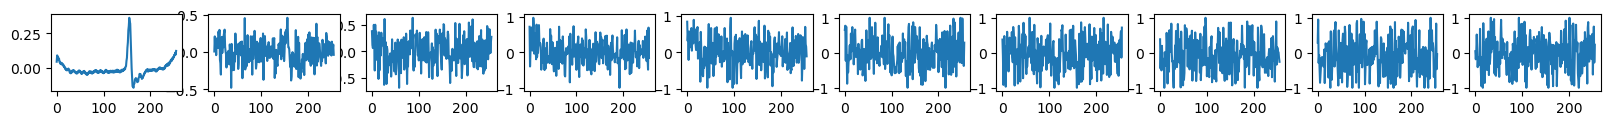

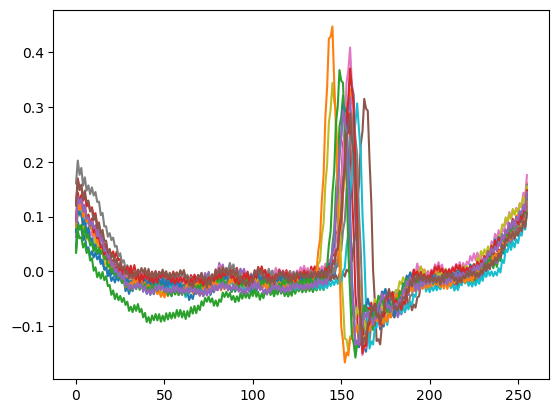

 80%|████████  | 400/500 [01:59<00:27,  3.66it/s]

Epoch 400 | Loss: 0.010927421972155571 


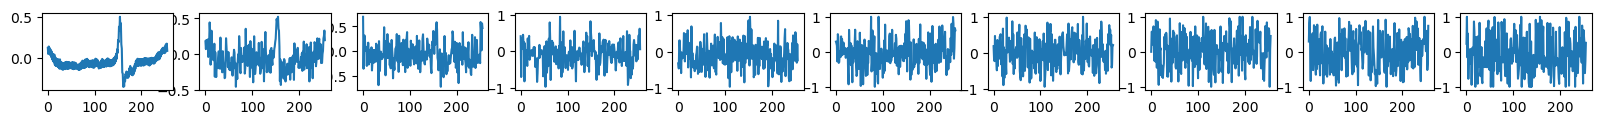

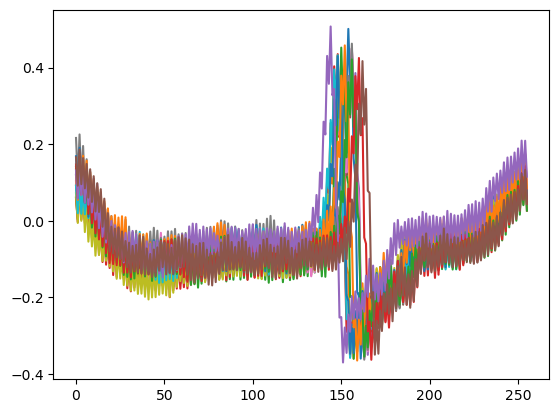

100%|██████████| 500/500 [02:28<00:00,  3.37it/s]


In [8]:


device = "cuda"
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.0001)
epochs = 500

loss_curve = []

for epoch in tqdm(range(epochs)):
    for b in batches:
        optimizer.zero_grad()

        t = torch.randint(0, T, (1,), device=device).long()
        
        loss = get_loss(model, data[b], t)
        loss_curve.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()} ")
        pred_img = sample_plot_image()
        vis(pred_img.detach().cpu())
        plt.show()

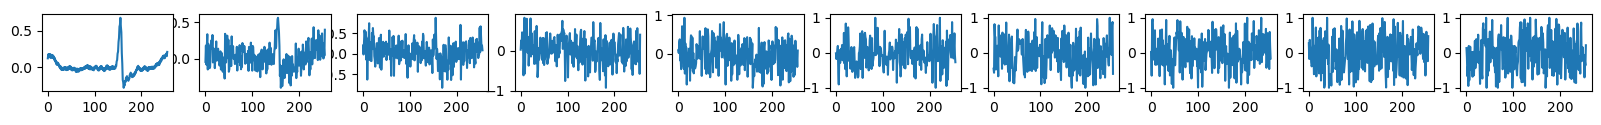

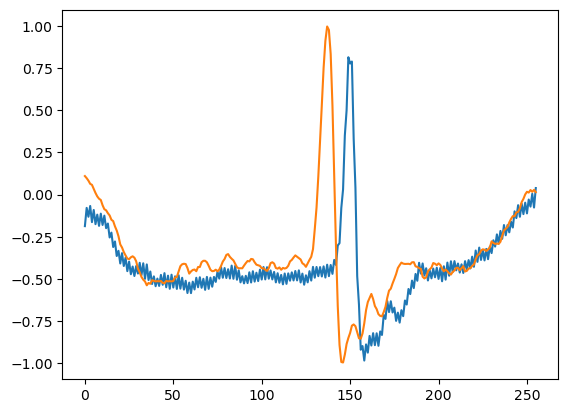

In [9]:
def rescale_tensor(x, new_min, new_max):
    current_min = x.min()
    current_max = x.max()
    
    normalized_x = (x - current_min) / (current_max - current_min)

    rescaled_x = normalized_x * (new_max - new_min) + new_min
    return rescaled_x

pred_img = sample_plot_image()
pred_img = rescale_tensor(pred_img, -1, 1)
vis(pred_img[4].detach().cpu())
c1 = np.random.randint(len(batches))
plt.plot(data.detach().cpu()[batches[c1][0]].transpose(0,1))
plt.show()

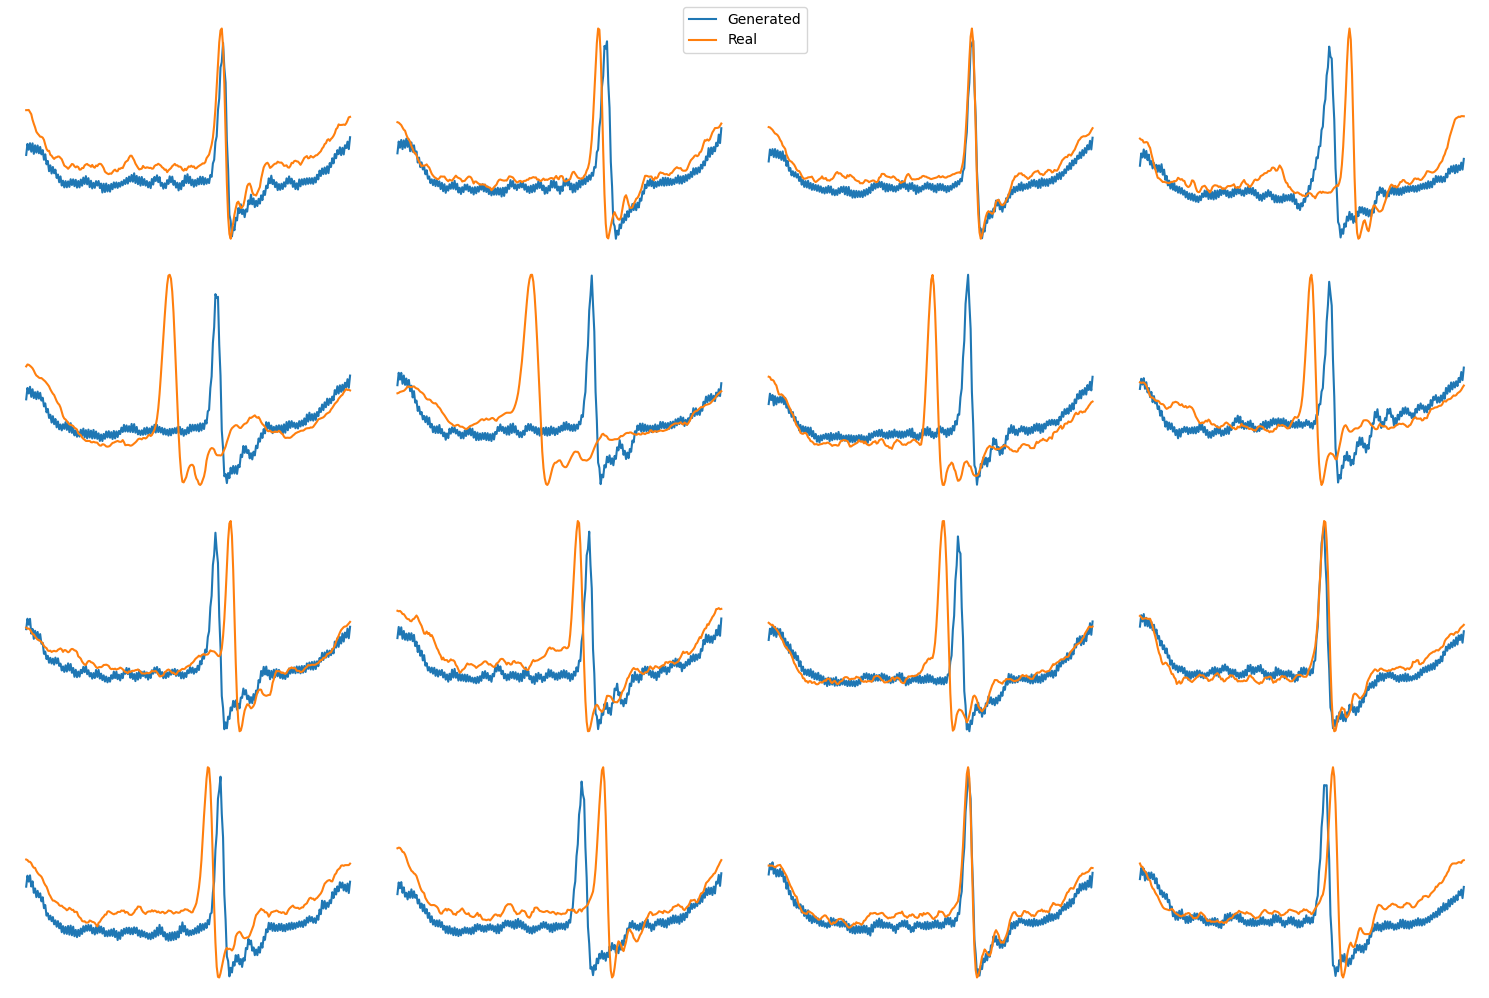

In [10]:
# save some signals
pred_img = pred_img.detach().cpu()
torch.save(pred_img, "./UnetAttn/"+LABEL[0]+"_1d.pt")


n = int(np.ceil(np.sqrt(pred_img.shape[0])))
fig, axes = plt.subplots(n, n, figsize=(15, 10))
axes = axes.flatten()
c1 = np.random.randint(len(batches))

for i,signal in enumerate(pred_img):
    axes[i].plot(signal.transpose(0,1), label="Generated")
    axes[i].plot(data.detach().cpu()[batches[c1][i]].transpose(0,1), label="Real")
    axes[i].grid(False)
    axes[i].axis('off')
    
plt.tight_layout()
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.savefig("./UnetAttn/"+LABEL[0]+"_1d.png")
plt.show()

In [11]:
# save model weights

path = './weights/unetattn/weights.pth'
torch.save(model.state_dict(), path)